# Audio Data Preparation

# Mount Google Drive to access data saved on drive
There will be a pop-up window where you have to log in with your Google account.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install libraries

In [18]:
!pip install -r "/content/drive/MyDrive/Projekt badawczy - terminy medyczne/Google Colab/requirements.txt" # adjust path to requiremnts.txt file
!pip install pydub

  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached mayavoz-0.0.1-py2.py3-none-any.whl.metadata (4.8 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pytorch_lightning-2.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached stack_data-0.6.3-py3-none-any.whl.metadata (18 kB)
  Using cached boto3-1.35.29-py3-none-any.whl.metadata (6.6 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached mlflow-2.16.2-py3-none-any.whl.metadata (29 kB)
  Using cached pesq-0.0.4-cp310-cp310-linux_x86_64.whl
  Using cached pystoi-0.3.3

# Unzip data into the main data directory

In [3]:
# create directory for data
!mkdir data

# unzip files from zip folder
!unzip "/content/drive/MyDrive/Projekt badawczy - terminy medyczne/001_004.zip" -d "data/"

Archive:  /content/drive/MyDrive/Projekt badawczy - terminy medyczne/001_004.zip
   creating: data/001_004/
  inflating: data/001_004/001_004_online.csv  
  inflating: data/001_004/004_00005_20230711T124716.wav  
  inflating: data/001_004/004_00017_20230711T124847.wav  


## Set the data directory
With *.wav files that are going to be processed.

In [ ]:
data_directory = "./data/001_004/"

# Resampling audio data

Based on the [Librosa documentation](https://librosa.org/blog/2019/07/17/resample-on-load/) - the sampling rate of the audio file is set during the loading of an audio file. The default resampling value is 22050.

## Using the original sampling rate
You can always bypass resample-on-load by specifying *sr=None* (then the audio file will be loaded with its original sampling rate):

```python
sr = 30000  # set sampling rate
y, sr = librosa.load(file_to_load, sr=sr)
```

In [50]:
import librosa
import pathlib
import os

# Set the sampling rate
sr = 48000

Example of loading an audio file using Liborsa with a defined sampling rate (sr)

In [51]:
data_path = pathlib.Path(data_directory)
# List the first 11 files in the directory
files = list(data_path.glob('*.wav'))
wav, sr = librosa.load(files[0], sr=sr)  # use your own sampling rate
print("wav:", wav)
print("sr:", sr)

wav: [ 0.          0.          0.         ... -0.00064087 -0.00048828
 -0.00030518]
sr: 48000


# Normalisation

The goal of normalisation is to adjust the volume of audio files to a standard set level; if this isn’t done, the volume can differ greatly from word to word, and the files can end up unable to be processed clearly.

In [42]:
import pathlib
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment, effects
import os

# Define the path to the directory containing audio files
data_path = pathlib.Path(data_directory)

# List only the .wav audio files in the directory
files = list(data_path.glob('*.wav'))

# Check if any .wav files were found
if not files:
    raise FileNotFoundError("No .wav files found in the specified directory.")

# Create a directory for normalized files if it doesn't exist
normalized_dir = os.path.join(data_directory, "normalised")
if not os.path.exists(normalized_dir):
    os.makedirs(normalized_dir)

# Enable/disable plotting
show_plot_results = False

# Loop through each .wav file and normalize
for file_to_normalize in files:
    # Load the raw audio file
    raw_sound, sr = librosa.load(file_to_normalize, sr=sr)

    # Convert the raw audio to AudioSegment object
    audio_segment = AudioSegment(
        raw_sound.tobytes(),
        frame_rate=sr,
        sample_width=raw_sound.dtype.itemsize,
        channels=1
    )

    # Normalize the audio using AudioSegment
    normalized_audio_segment = effects.normalize(audio_segment)

    # Extract the filename and define the path for the normalized file
    filename = str(file_to_normalize).split('/')[-1].split('.')[0]
    normalized_temp_file = os.path.join(normalized_dir, filename + '_normalised.wav')

    # Export the normalized audio segment to the specified path
    normalized_audio_segment.export(normalized_temp_file, format="wav")

    # Load the normalized audio using librosa
    normalized_sound, _ = librosa.load(normalized_temp_file, sr=sr)

    # Plot waveform and spectrogram for original and normalized audio if plotting is enabled
    if show_plot_results:
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        librosa.display.waveshow(raw_sound, sr=sr)
        plt.title('Original Waveform: ' + filename)

        plt.subplot(2, 2, 2)
        librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(raw_sound), ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Original Spectrogram: ' + filename)

        # Plot waveform and spectrogram for normalized audio
        plt.subplot(2, 2, 3)
        librosa.display.waveshow(normalized_sound, sr=sr)
        plt.title('Normalized Waveform: ' + filename)

        plt.subplot(2, 2, 4)
        librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(normalized_sound), ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Normalized Spectrogram: ' + filename)

        plt.tight_layout()
        plt.show()


# Pre-emphasis

**Preemphasis is a signal processing technique used in audio processing to boost the high-frequency components of a sound signal.** This is particularly beneficial for improving the clarity and intelligibility of speech signals, as it compensates for the natural roll-off of high frequencies that occurs in many recording and transmission systems. By applying preemphasis, the signal becomes more robust against noise and distortion, ultimately enhancing the performance of subsequent processing tasks such as feature extraction and recognition.

**It is used to ensure better quality and accuracy in the resulting audio output.**

In [45]:
import matplotlib.pyplot as plt
import pathlib
import librosa
import librosa.display
import numpy as np
import soundfile as sf

# Define the path to the directory containing audio files
data_path = pathlib.Path(data_directory)

# List only the .wav audio files in the directory
files = list(data_path.glob('*.wav'))

# Check if there are any .wav files found
if not files:
    print("No .wav files found in the directory.")
else:
    # Create a directory for preemphasised files if it doesn't exist
    preemphasised_dir = os.path.join(data_directory, "preemphasised")
    if not os.path.exists(preemphasised_dir):
      os.makedirs(preemphasised_dir)

    # Enable/disable plotting
    show_plot_results = False

    # Loop through each .wav file
    for file_to_load in files:
        # Load the audio file
        y, sr = librosa.load(file_to_load, sr=sr)
        filename = str(file_to_load).split('/')[-1].split('.')[0]

        # Apply pre-emphasis
        y_filt = librosa.effects.preemphasis(y)

        # Compute spectrograms for original and pre-emphasized signals
        S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max)

        # Plotting the results if enabled
        if show_plot_results:
            plt.figure(figsize=(12, 6))

            # Plot original signal
            plt.subplot(1, 2, 1)
            librosa.display.specshow(S_orig, y_axis='log', x_axis='time')
            plt.title('Original signal: ' + filename)

            # Plot pre-emphasized signal
            plt.subplot(1, 2, 2)
            librosa.display.specshow(S_preemph, y_axis='log', x_axis='time')
            plt.title('Pre-emphasized signal: ' + filename)

            plt.tight_layout()
            plt.show()

        # Save the pre-emphasized audio
        sf.write(preemphasised_dir + f'/{filename}_preemphasis.wav', y_filt, sr)

In [37]:
import IPython.display as ipd
print("original:")
ipd.Audio(data=y,rate=sr)

original:



# Audio Data Augmentation

Code comes from: [audio-data-augmentation-visualization-librosa-notebook](https://gist.github.com/keyurparalkar/5a49f696ed36ddce6526ab50e29e04ce).


## Import libraries

In [ ]:
from fastai import *
from fastai.vision import *
import pathlib
import os
from scipy import signal
from scipy.io import wavfile
from fastprogress import progress_bar
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

## Load sample data

In [ ]:
data_path = pathlib.Path('./data/001_004/')
# List the first 11 files in the directory
files = list(data_path.glob('*'))
print(files)

[PosixPath('data/001_004/004_00005_20230711T124716.wav'), PosixPath('data/001_004/004_00017_20230711T124847.wav'), PosixPath('data/001_004/001_004_online.csv')]


## Original

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


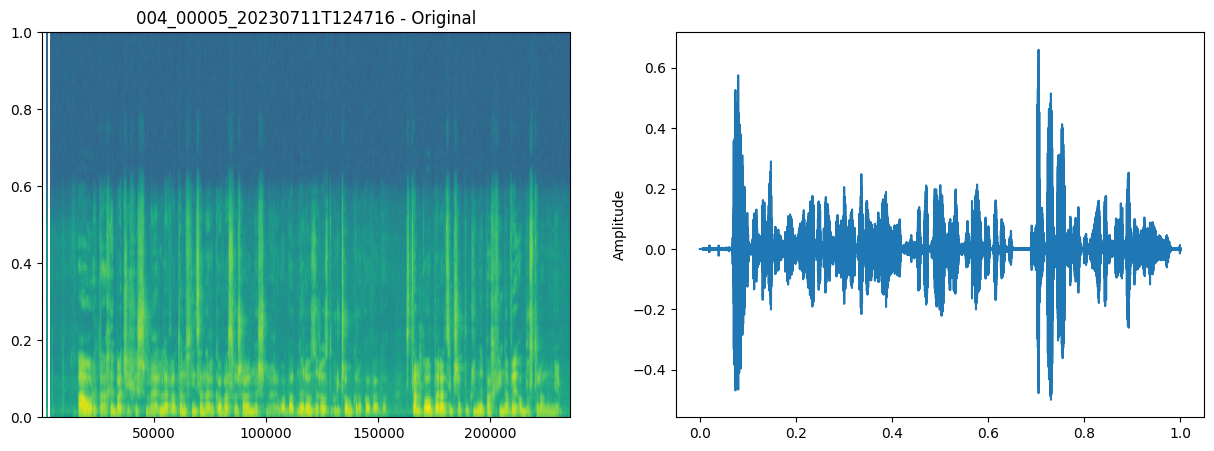

In [ ]:
def plot_spec(data:np.array,sr:int,title:str, fpath:str, save_to_file=False) -> None:
    filename = str(fpath).split('/')[-1].split('.')[0]

    # plot graphs
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].title.set_text(f'{filename} - {title}')
    ax[0].specgram(data,Fs=2)
    # fig.savefig('temp1.png',bbox_inches="tight",pad_inches=0)
    ax[1].set_ylabel('Amplitude')
    ax[1].plot(np.linspace(0,1,len(data)), data)

    # save sound to a new file
    if save_to_file:
        sf.write(filename + '_' + save_to_file + '.wav', data, sr)


file_path = files[0]
wav, sr = librosa.load(file_path, sr=sr)
sound_name = 'Original'
plot_spec(wav, sr, sound_name, file_path, save_to_file = sound_name)
ipd.Audio(data=wav,rate=sr)

## Noise addition

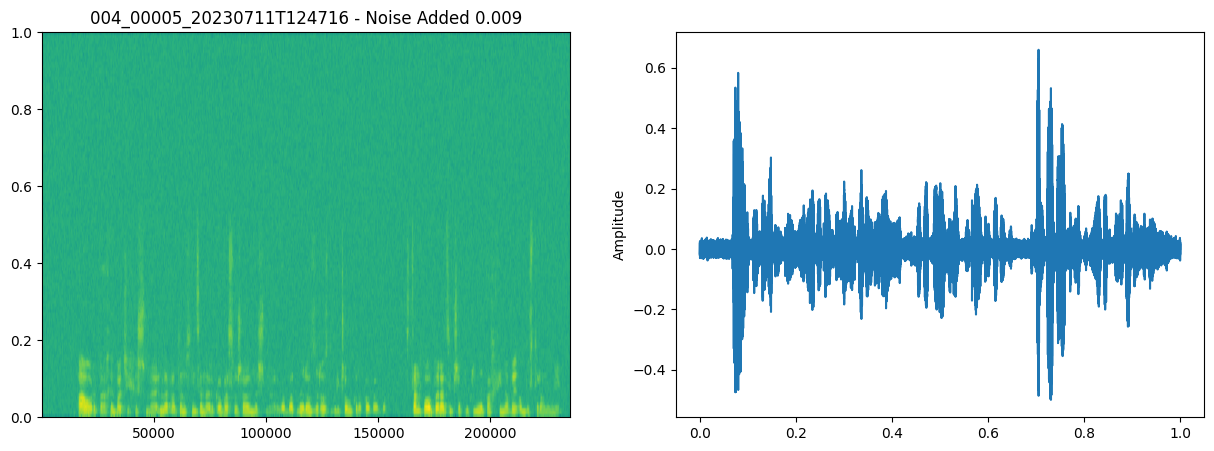

In [ ]:
'''
Noise addition using normal distribution with mean = 0 and std =1

Permissible noise factor value = x > 0.004
'''
wav_n = wav + 0.009*np.random.normal(0,1,len(wav))
sound_name = 'WhiteNoise'
plot_spec(wav_n,sr,'Noise Added 0.009', file_path, save_to_file = sound_name)
ipd.Audio(data=wav_n,rate=sr)

## Shifting the sound wave

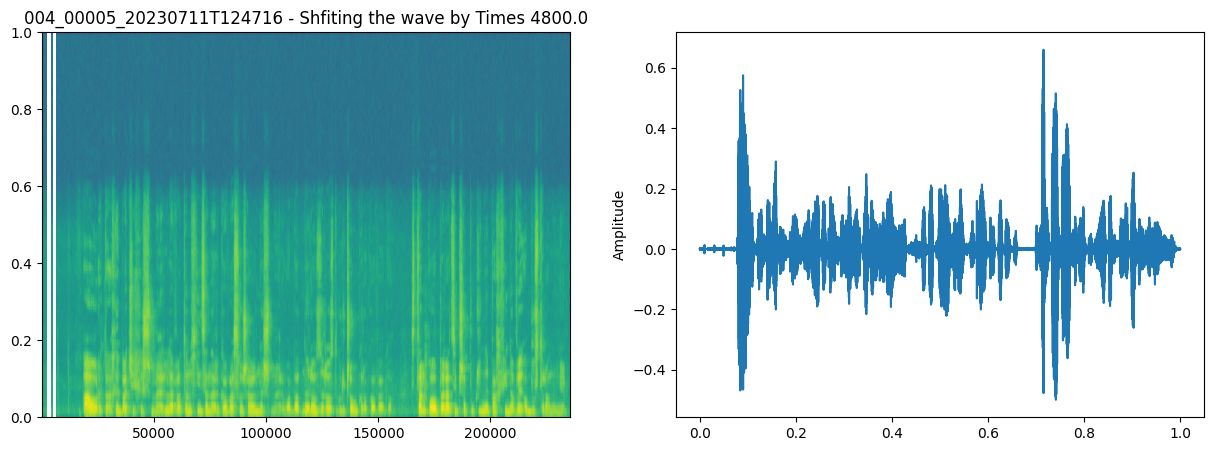

In [ ]:
'''
Permissible factor values = sr/10
'''

wav_roll = np.roll(wav,int(sr/10))
ipd.Audio(wav_roll,rate=sr)
sound_name = 'TimeShift'
plot_spec(data=wav_roll,sr=sr,title=f'Shfiting the wave by Times {sr/10}',fpath=file_path, save_to_file = sound_name)


## Time-stretching

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


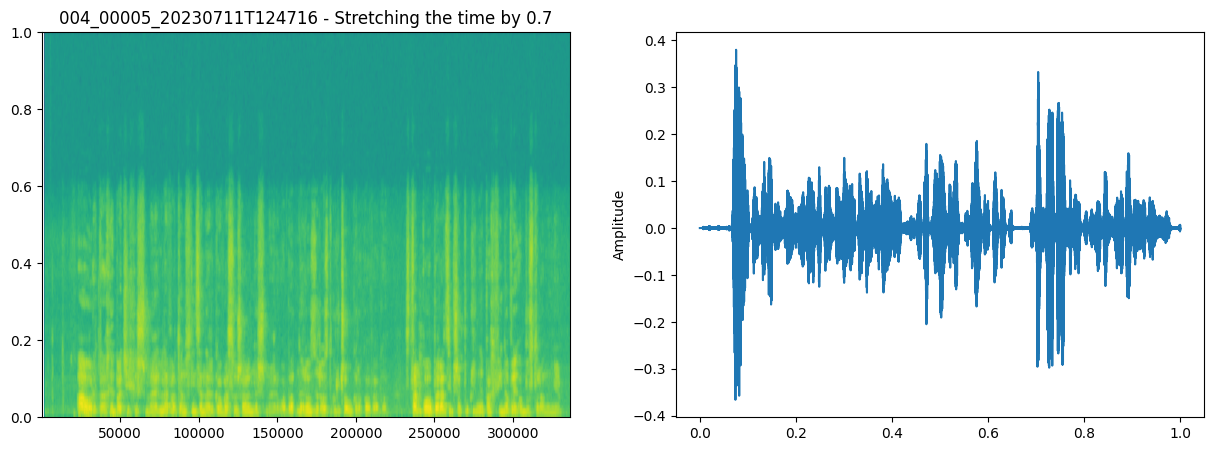

In [ ]:
'''
Permissible factor values = 0 < x < 1.0
'''

factor = 0.7
wav_time_stch = librosa.effects.time_stretch(y=wav,rate=factor)
sound_name = 'TimeStrech'
plot_spec(data=wav_time_stch,sr=sr,title=f'Stretching the time by {factor}',fpath=file_path, save_to_file = sound_name)
ipd.Audio(wav_time_stch,rate=sr)



## Pitch shifting

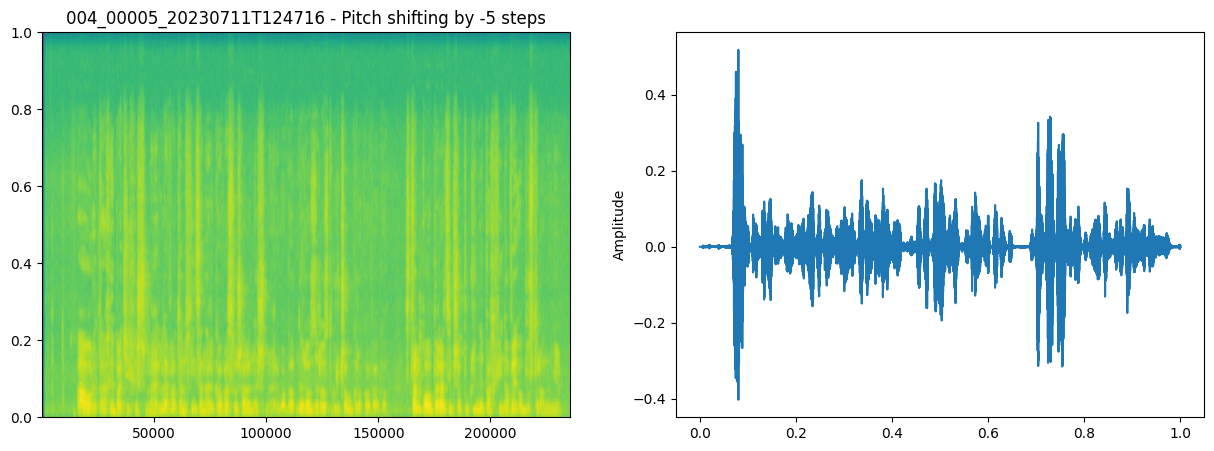

In [ ]:
'''
Permissible factor values = -5 <= x <= 5
'''
wav_pitch_sf = librosa.effects.pitch_shift(y=wav,sr=sr,n_steps=5)
sound_name = 'PitchShift'
plot_spec(data=wav_pitch_sf,sr=sr,title=f'Pitch shifting by {-5} steps',fpath=file_path, save_to_file = sound_name)
ipd.Audio(wav_pitch_sf,rate=sr)

# Create requirements.txt file

In [ ]:
# pipreqs [options] [<path>]
!pipreqsnb --savepath "/content/drive/MyDrive/Projekt badawczy - terminy medyczne/Google Colab/requirements.txt" .

pipreqs  --savepath /content/drive/MyDrive/Projekt badawczy - terminy medyczne/Google Colab/requirements.txt .
Usage:
    pipreqs [options] [<path>]


-----------------------------------